In [1]:
import numpy as np

from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
from scipy.io import loadmat
from ImageProcessing import *

import matplotlib.pyplot as plt
import matplotlib.scale as scale

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

# Loading Data

In [2]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

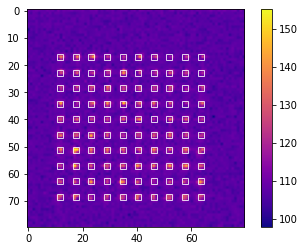

In [12]:

processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

# Creating Labels with Thresholding Algorithm

In [13]:
crops, labels = processor.make_dataset(keep_unknowns=True)

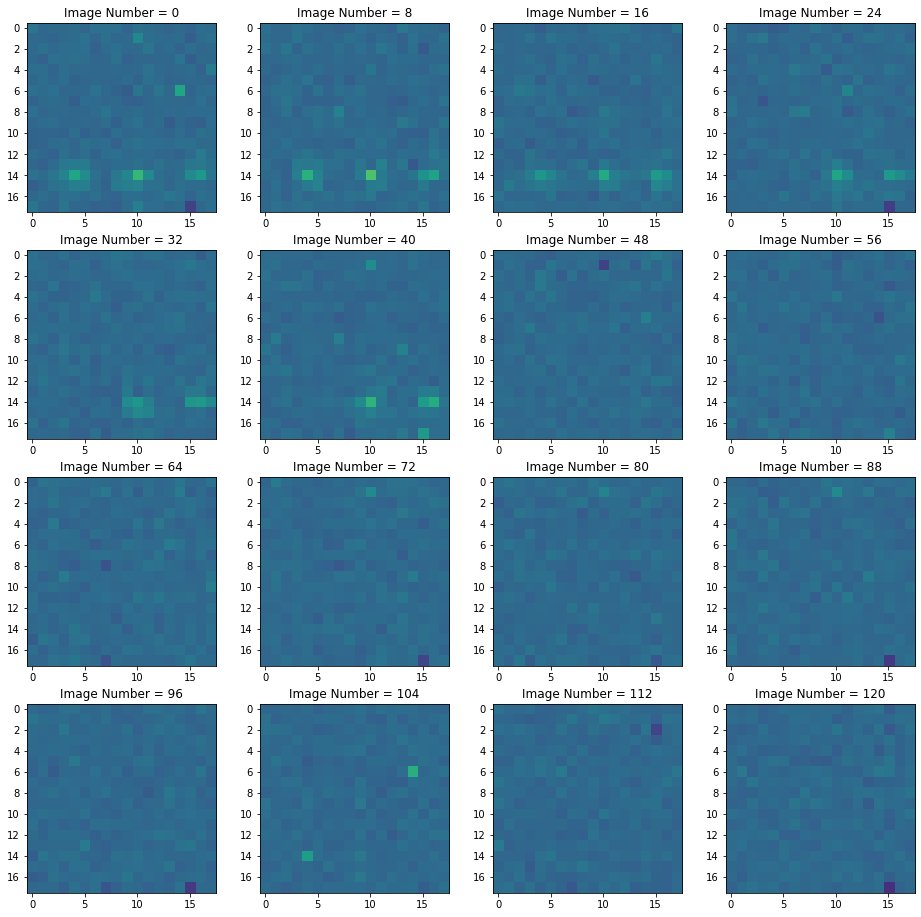

In [19]:
#i, j, k = np.random.randint(processor.n_tweezers), np.random.randint(processor.n_loops), np.random.randint(processor.per_loop - 4)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for n in range(16):
    axs[n // 4, np.mod(n, 4)].imshow(crops[processor.crop_index(0, 19, 8 * n)], vmin=processor.stack.min(), vmax=processor.stack.max())
    axs[n // 4, np.mod(n, 4)].set_title(f"Image Number = {8 * n}")

28


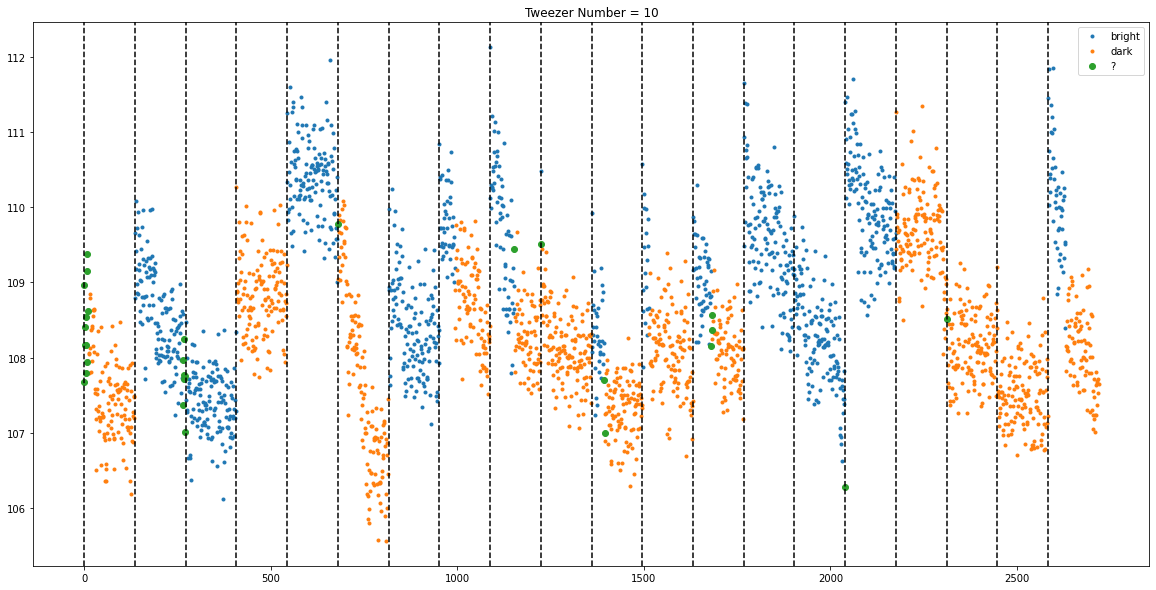

In [24]:
tweezer = 10
tweezer_vals = np.mean(crops[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)], axis=(1, 2))
tweezer_labels = labels[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)]

bright_mask = tweezer_labels == 1
dark_mask = tweezer_labels == 0
unknown_mask = np.isnan(tweezer_labels)

bright_indices = np.where(bright_mask)[0]
bright_vals = tweezer_vals[bright_mask]

dark_indices = np.where(dark_mask)[0]
dark_vals = tweezer_vals[dark_mask]

unknown_indices = np.where(unknown_mask)[0]
unknown_vals = tweezer_vals[unknown_mask]

print(len(unknown_vals))
plt.figure(figsize=(20, 10))
plt.plot(bright_indices, bright_vals, '.', label='bright')
plt.plot(dark_indices, dark_vals, '.', label='dark')
plt.plot(unknown_indices, unknown_vals, 'o', label='?')
#plt.axhline(upper_threshold, color='r', linestyle='--', label=f"Upper Threshold = {upper_threshold}")
#plt.axhline(lower_threshold, color='g', linestyle='--', label=f"Lower Threshold = {lower_threshold}")
plt.legend()
plt.title(f"Tweezer Number = {tweezer}")
for i in range(n_loops):
    plt.axvline(i * processor.per_loop, color='k', linestyle='--')
plt.show()

(array([ 2.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  2.,  1.,  1.,  1.,  5.,
         1.,  1.,  6.,  6.,  1.,  5.,  6.,  3.,  6.,  8.,  5.,  6.,  8.,
        13., 13., 22., 19., 17., 29., 20., 22., 35., 24., 30., 34., 31.,
        38., 40., 54., 41., 51., 46., 41., 50., 53., 47., 58., 46., 45.,
        52., 62., 59., 55., 58., 40., 37., 52., 46., 43., 43., 52., 40.,
        31., 40., 40., 29., 36., 37., 31., 27., 22., 34., 31., 29., 25.,
        26., 34., 30., 33., 19., 17., 25., 25., 24., 20., 29., 29., 21.,
        26., 16., 18., 20., 12., 23., 23., 14., 22., 15., 16., 16., 21.,
         6., 11.,  5., 10.,  6.,  6.,  3.,  3.,  8.,  6.,  5.,  3.,  1.,
         4.,  3.,  4.,  5.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         2.,  0.,  1.,  0.,  0.,  1.]),
 array([105.55555556, 105.60393972, 105.65232389, 105.70070806,
        105.74909223, 105.7974764 , 105.84586057, 105.89424473,
        105.9426289 , 105.99101307, 106.03939724, 106.08778141,
        106.13616558, 106.18454975, 10

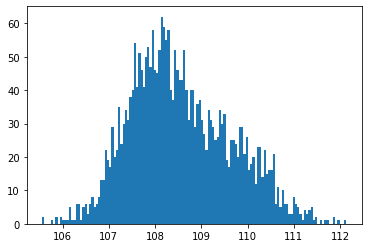

In [27]:
plt.hist(np.mean(crops[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)], axis=(1, 2)), bins=78)

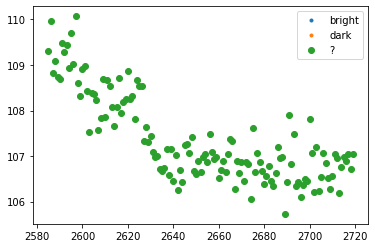

In [7]:
loop_num = 19
low = processor.per_loop * loop_num
high = processor.per_loop * (loop_num + 1)
bright_mask = (low < bright_indices) & (bright_indices < high)
dark_mask = (low < dark_indices) & (dark_indices < high)
unknown_mask = (low < unknown_indices) & (unknown_indices < high)

plt.plot(bright_indices[bright_mask], bright_vals[bright_mask], '.', label='bright')
plt.plot(dark_indices[dark_mask], dark_vals[dark_mask], '.', label='dark')
plt.plot(unknown_indices[unknown_mask], unknown_vals[unknown_mask], 'o', label='?')
#plt.axhline(upper_threshold, color='r', linestyle='--')
#plt.axhline(lower_threshold, color='r', linestyle='--')
plt.legend()
plt.show()

# Making a Neural Network For Training

In [8]:
images, labels = processor.make_dataset()


1.0


[]

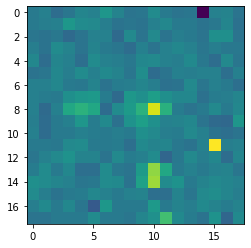

In [9]:
i = np.where(labels == 1)[0][0]
print(labels[i])
plt.imshow(images[i])
plt.plot()

In [10]:
model = models.Sequential()
model.add(layers.Input(shape=(images.shape[1], images.shape[2], 1)))
model.add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 10)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
#classifier = ImageClassifier(model)
#model.fit(images, labels, epochs=5)

# TODO
* Fine tune the thresholds for labeling 
* Automate testing and training for different hyperparameters
* Make multiple models to compare against each other
* Play around with individual site thresholds